In [1]:
import os

import hydra
import torch
import torchaudio
from stable_audio_tools.inference.generation import generate_diffusion_cond

/homes/rfg543/.conda/envs/stableaudio/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# params
seed = 42
num_samples = 2
exp_cfg = "train_gh_controlnet"
ckpt_path = "/homes/rfg543/Documents/Stable-Video2Audio/logs/ckpts/gh-controlnet_2024-08-22-11-43-14/last.ckpt"
dataset_path = "/import/c4dm-datasets-ext/DIFF-SFX/GREATEST-HITS-DATASET/mic-mp4-processed-4fps-16kHz/"

torch.cuda.set_device(3)

import sys
sys.path.append("..")

# load config
with hydra.initialize(config_path="..", version_base=None):
    cond_cfg = hydra.compose(config_name="config", overrides=[f'exp={exp_cfg}',
                                                              f"datamodule.test_split_file_path={dataset_path}/test.txt",
                                                              f"datamodule.test_data_to_use=0.1",])
    
# init model
model = hydra.utils.instantiate(cond_cfg["model"])
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt['state_dict'], strict=False)
model = model.cuda()

# load dataloader
datamodule = hydra.utils.instantiate(cond_cfg["datamodule"])
datamodule.setup(stage="test")
test_dataloader = datamodule.test_dataloader()

No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention
Initalize Stage1 CAVP Model
Loading Stage1 CAVP Model from: /import/c4dm-datasets-ext/DIFF-SFX/logs/diff_foley/diff_foley_ckpt/cavp_epoch66.ckpt
Restored from /import/c4dm-datasets-ext/DIFF-SFX/logs/diff_foley/diff_foley_ckpt/cavp_epoch66.ckpt with 0 missing and 0 unexpected keys


/homes/rfg543/.conda/envs/stableaudio/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



Greatesthit test dataset:
num test chunks: 52
chunk frames size: torch.Size([3, 40, 224, 224])
chunk audio size: torch.Size([2, 441000])


In [3]:
# load conditioning (replace with your audio and prompts; prompts must follow "in: stems; out:stems" structure)
from main.module_controlnet import window_rms, low_pass_filter

rms_window_size = 10000
low_pass_window_size = 2000

x, frames, seconds_start, seconds_total, item = next(iter(test_dataloader))
# y = torch.clip(y, -1, 1)
rms_envelope = window_rms(x, window_size=rms_window_size)
filtered_envelope = low_pass_filter(rms_envelope, window_size=low_pass_window_size)
num_samples = min(num_samples, x.shape[0])
device = next(model.parameters()).device

# manipulate envelope if you want, i.e. 1) zero out some parts, 2) reduce amplitude of some parts
# filtered_envelope[:, :, 220500:] = 0 # zero out
# filtered_envelope[:, :, 220500:] *= 0.5 # reduce amplitude
filtered_envelope[:, :, 220500:] = -1 # set to -1

conditioning = [{
    "envelope": filtered_envelope[i:i+1].to(device),
    "audio": x[i:i+1],
    "frames": frames[i:i+1],
    "seconds_start": seconds_start[i],
    "seconds_total": seconds_total[i],
} for i in range(num_samples)]

In [4]:
# generate 

output = generate_diffusion_cond(
            model.model,
            seed=seed,
            batch_size=num_samples,
            steps=100,
            cfg_scale=7.0,
            conditioning=conditioning,
            sample_size=x.shape[-1],
            sigma_min=0.3,
            sigma_max=500,
            sampler_type="dpmpp-3m-sde",
            device="cuda"
        )

42


/homes/rfg543/.conda/envs/stableaudio/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]/homes/rfg543/.conda/envs/stableaudio/lib/python3.8/site-packages/torchsde/_brownian/brownian_interval.py:608: UserWarning: Should have tb<=t1 but got tb=500.00006103515625 and t1=500.000061.
  warnings.warn(f"Should have {tb_name}<=t1 but got {tb_name}={tb} and t1={self._end}.")
100%|██████████| 100/100 [00:06<00:00, 14.50it/s]


In [5]:
# save results
if "out_4" not in os.listdir():
    os.mkdir("out_4")

for i in range(num_samples):
    video_name = item[i]["video_name"]
    torchaudio.save(f"out_4/input_{i}_video_{video_name}.wav", x[i].cpu(), sample_rate=44100)
    torchaudio.save(f"out_4/output_{i}_video_{video_name}.wav", output[i].cpu(), sample_rate=44100)

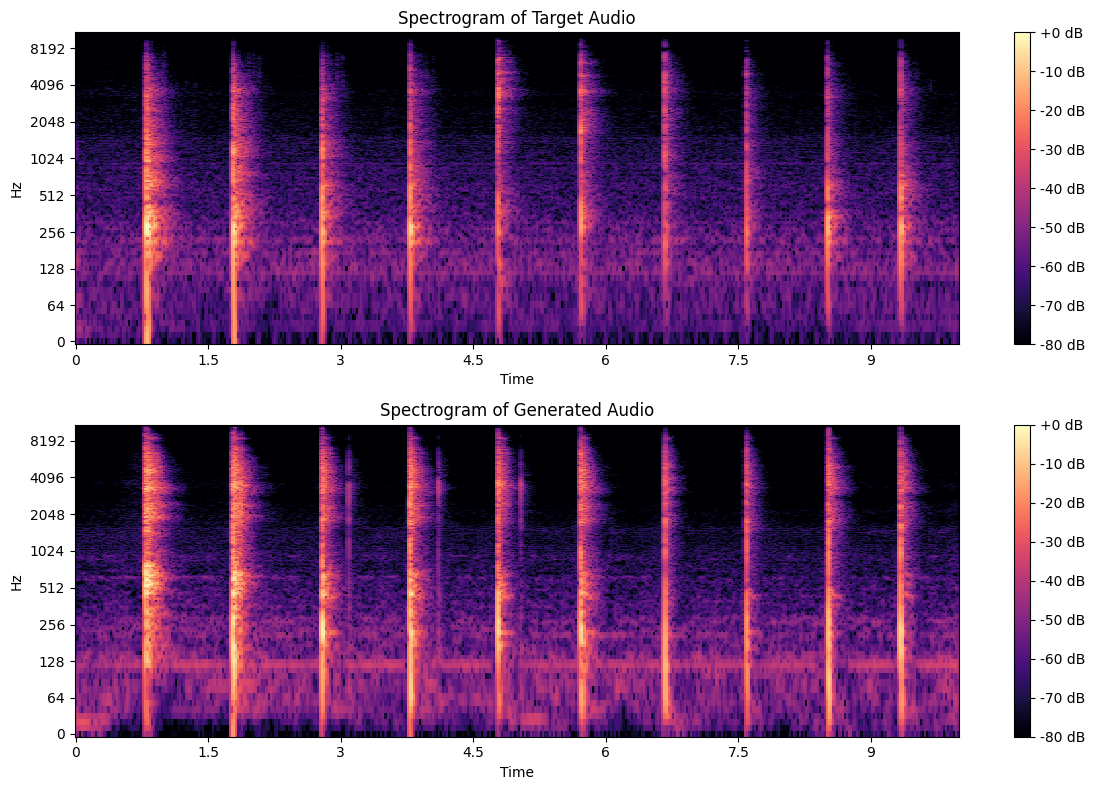

In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

audio_path1 = "/homes/rfg543/Documents/Stable-Video2Audio/notebook/out/input_0_video_2015-02-22-14-20-13.wav"
audio_path2 = "/homes/rfg543/Documents/Stable-Video2Audio/notebook/out/output_0_video_2015-02-22-14-20-13.wav"

y1, sr1 = librosa.load(audio_path1)
y2, sr2 = librosa.load(audio_path2)

D1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(D1, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Target Audio')

plt.subplot(2, 1, 2)
librosa.display.specshow(D2, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Generated Audio')

plt.tight_layout()
plt.show()

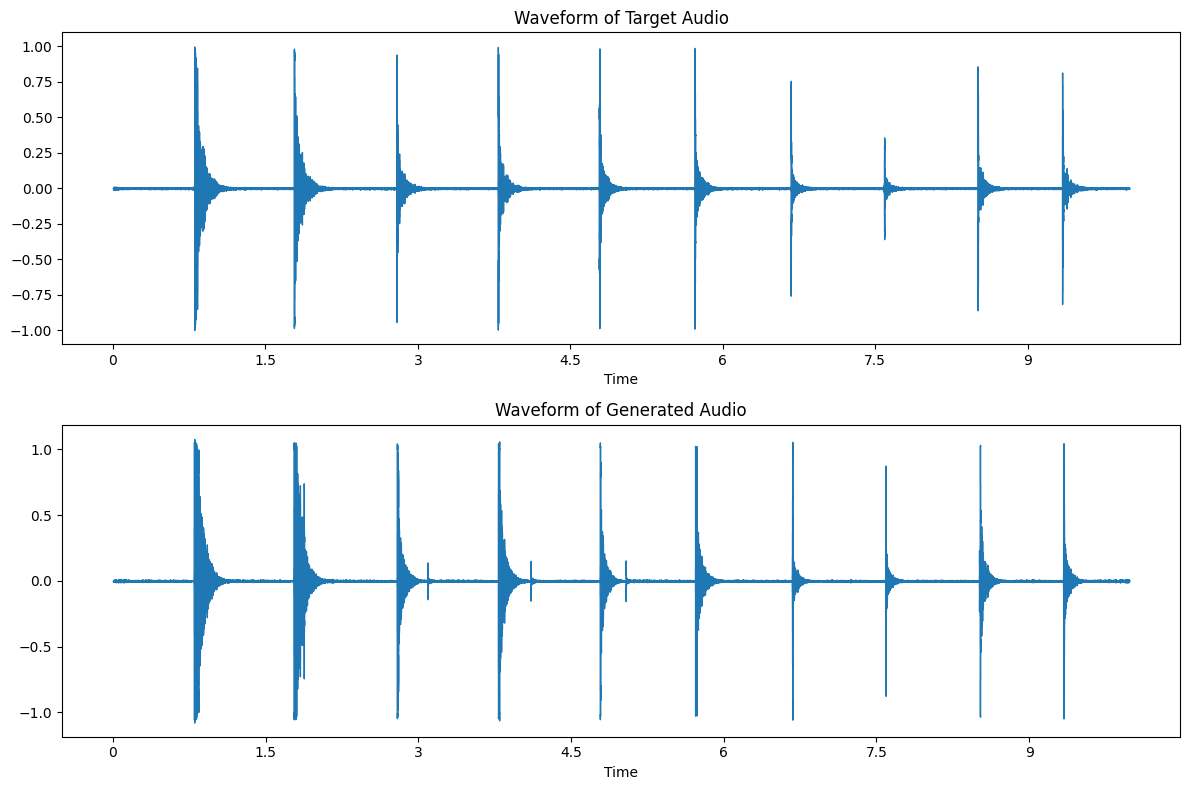

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y1, sr=sr1)
plt.title('Waveform of Target Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y2, sr=sr2)
plt.title('Waveform of Generated Audio')

plt.tight_layout()
plt.show()